## iris 데이터에  PCA 적용하기

In [1]:
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 사이킷런 내장 데이터 셋 API 호출
iris = load_iris()

# Numpy Dataset -> Pandas DataFrame으로 변환
columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
irisDF = pd.DataFrame(iris.data, columns=columns)
irisDF['target'] = iris.target
irisDF.head(3)

,sepal_length,sepal_width,petal_length,petal_width,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0


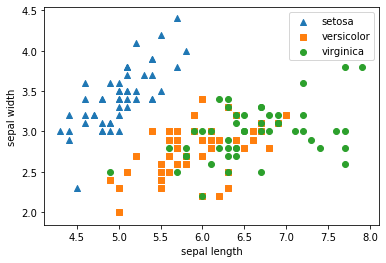

In [2]:
# setosa: 세모, versicolor: 네모, virginica: 동그라미
markers = ['^', 's', 'o']

# setosa: 0, versicolor: 1, virginica:2 
# 각 target 별로 다른 shape로 scatterplot 그리기
for i, marker in enumerate(markers):
    x_axis_data = irisDF[iris['target']==i]['sepal_length']
    y_axis_data = irisDF[iris['target']==i]['sepal_width']
    plt.scatter(x_axis_data, y_axis_data, marker=marker, label=iris.target_names[i])
    
plt.legend()
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.show()

In [3]:
# PC의 개수 구하는 방법1: scree plot
from sklearn.preprocessing import StandardScaler
iris_scaled = StandardScaler().fit_transform(irisDF.iloc[:,:-1])
iris_scaled.shape

(150, 4)

In [4]:
# n_components=4로 수행
from sklearn.decomposition import PCA
pca = PCA(n_components=4)

# fit()과 transform()을 호출하여 PCA 변환데이터 반환
pca.fit(iris_scaled)
iris_pca = pca.transform(iris_scaled)
print(iris_pca.shape)

(150, 4)


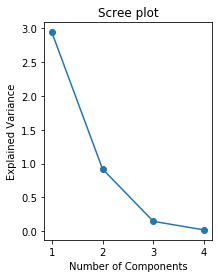

In [5]:
pc_values = np.arange(pca.n_components_)+1

plt.figure(figsize=(3,4))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.plot(pc_values, pca.explained_variance_, 'o-')
plt.title('Scree plot')
plt.show()

# 그러나 사실 Scree plot 만으로는 완만해지는 지점을 명확히 하기 어려우므로 
# 보통은 '변동성 비율'과 '누적 변동성 비율'을 주로 이용

In [12]:
# PC의 개수 구하는 방법2: 변동성 비율 & 누적 변동성 비율
cumsum = np.cumsum(pca.explained_variance_ratio_)
result = pd.DataFrame({'고유값': pca.explained_variance_ratio_,
                    '변동성비율': pca.explained_variance_ratio_},
                    index = np.array([f'pca{num+1}' for num in range(iris_scaled.shape[1])]))
result['누적변동성비율'] = result['변동성비율'].cumsum()
result

,고유값,변동성비율,누적변동성비율
pca1,0.729624,0.729624,0.729624
pca2,0.228508,0.228508,0.958132
pca3,0.036689,0.036689,0.994821
pca4,0.005179,0.005179,1.000000


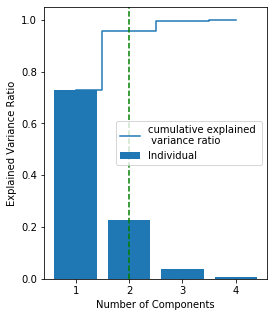

In [13]:
num_d = np.argmax(cumsum>=0.80)+1

var_ratio = pd.DataFrame({'Variance': pca.explained_variance_ratio_, 'n_components': range(1,5)})

plt.figure(figsize=(4,5))
plt.bar('n_components', 'Variance', data=var_ratio, label='Individual')
plt.step(range(1,5), cumsum, where='mid', label='cumulative explained \n variance ratio')
plt.axvline(num_d, color='g', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.legend()
plt.show()

In [14]:
# n_components=2로 차원축소된 피처들로 데이터 산포도 시각화
pca = PCA(n_components=2)

#fit( )과 transform( ) 을 호출하여 PCA 변환 데이터 반환
pca.fit(iris_scaled)
iris_pca = pca.transform(iris_scaled)
print(iris_pca.shape)

(150, 2)


In [15]:
# PCA 변환된 데이터의 컬럼명을 각각 pca_component_1, pca_component_2로 명명
pca_columns=['pca_component_1','pca_component_2']
irisDF_pca = pd.DataFrame(iris_pca,columns=pca_columns)
irisDF_pca['target']=iris.target
irisDF_pca.head(3)

,pca_component_1,pca_component_2,target
0,-2.264703,0.480027,0
1,-2.080961,-0.674134,0
2,-2.364229,-0.341908,0


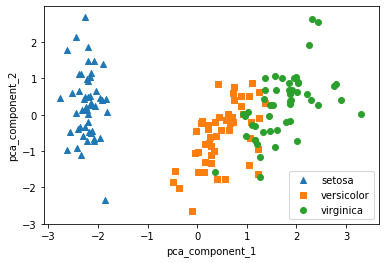

In [16]:
#setosa를 세모, versicolor를 네모, virginica를 동그라미로 표시
markers=['^', 's', 'o']

#pca_component_1 을 x축, pc_component_2를 y축으로 scatter plot 수행. 
for i, marker in enumerate(markers):
    x_axis_data = irisDF_pca[irisDF_pca['target']==i]['pca_component_1']
    y_axis_data = irisDF_pca[irisDF_pca['target']==i]['pca_component_2']
    plt.scatter(x_axis_data, y_axis_data, marker=marker,label=iris.target_names[i])

plt.legend()
plt.xlabel('pca_component_1')
plt.ylabel('pca_component_2')
plt.show()

In [17]:
# 각 PCA Components별 변동성 비율
pca.explained_variance_ratio_

array([0.72962445, 0.22850762])

In [19]:
# 원본데이터와 PCA 변환데이터 예측 성능 비교
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rcf = RandomForestClassifier(random_state=156)
scores = cross_val_score(rcf, iris.data, iris.target,scoring='accuracy',cv=3)
print('원본 데이터 교차 검증 개별 정확도:', scores)
print('원본 데이터 평균 정확도:', np.mean(scores))

원본 데이터 교차 검증 개별 정확도: [0.98 0.94 0.96]
원본 데이터 평균 정확도: 0.96


In [20]:
pca_X = irisDF_pca[['pca_component_1', 'pca_component_2']]
scores_pca = cross_val_score(rcf, pca_X, iris.target, scoring='accuracy', cv=3)
print('PCA 변환 데이터 교차 검증 개별 정확도:', scores_pca)
print('PCA 변환 데이터 평균 정확도:', np.mean(scores_pca))

PCA 변환 데이터 교차 검증 개별 정확도: [0.88 0.88 0.88]
PCA 변환 데이터 평균 정확도: 0.88


# PCA 실습2

## 신용카드 데이터셋 PCA 변환

In [24]:
import pandas as pd

df = pd.read_excel('C:/Users/USER/BITAmin/data/default of credit card clients.xls', header=1, sheet_name='Data')
print(df.shape)
df.head(3)

(30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0


In [26]:
df.rename(columns={'PAY_0':'PAY_1','default payment next month':'default'}, inplace=True)
y_target = df['default']
X_features = df.drop(['ID','default'], axis=1)

In [28]:
y_target.value_counts()

0    23364
1     6636
Name: default, dtype: int64

In [30]:
X_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 23 columns):
LIMIT_BAL    30000 non-null int64
SEX          30000 non-null int64
EDUCATION    30000 non-null int64
MARRIAGE     30000 non-null int64
AGE          30000 non-null int64
PAY_1        30000 non-null int64
PAY_2        30000 non-null int64
PAY_3        30000 non-null int64
PAY_4        30000 non-null int64
PAY_5        30000 non-null int64
PAY_6        30000 non-null int64
BILL_AMT1    30000 non-null int64
BILL_AMT2    30000 non-null int64
BILL_AMT3    30000 non-null int64
BILL_AMT4    30000 non-null int64
BILL_AMT5    30000 non-null int64
BILL_AMT6    30000 non-null int64
PAY_AMT1     30000 non-null int64
PAY_AMT2     30000 non-null int64
PAY_AMT3     30000 non-null int64
PAY_AMT4     30000 non-null int64
PAY_AMT5     30000 non-null int64
PAY_AMT6     30000 non-null int64
dtypes: int64(23)
memory usage: 5.3 MB


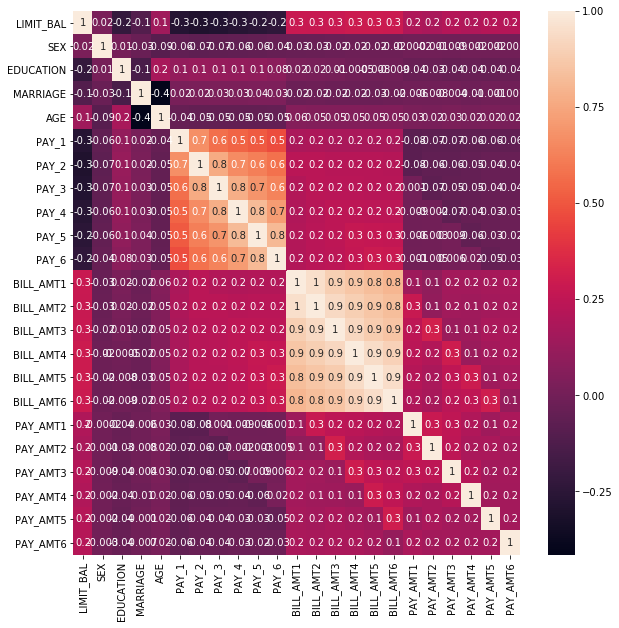

In [32]:
# 피처 간 상관도 시각화
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

corr = X_features.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True, fmt='.1g')

In [33]:
# 상관도가 높은 피처들 PCA 변환 후 변동성 확인
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#BILL_AMT1 ~ BILL_AMT6 까지 6개의 속성명 생성
cols_bill = ['BILL_AMT'+str(i) for i in range(1,7)]
print('대상 속성명:',cols_bill)

# 2개의 PCA 속성을 가진 PCA 객체 생성하고, explained_variance_ratio_ 계산 위해 fit( ) 호출
scaler = StandardScaler()
df_cols_scaled = scaler.fit_transform(X_features[cols_bill])
pca = PCA(n_components=2)
pca.fit(df_cols_scaled) 

print('PCA Component별 변동성:', pca.explained_variance_ratio_)

대상 속성명: ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
PCA Component별 변동성: [0.90555253 0.0509867 ]


In [34]:
# 원본데이터셋과 6개의 컴포넌트로 PCA 변환된데이터셋으로 분류 예측 성능 비교
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rcf = RandomForestClassifier(n_estimators=300, random_state=156)
scores = cross_val_score(rcf, X_features, y_target, scoring='accuracy', cv=3)

print('CV=3 인 경우의 개별 Fold세트별 정확도:',scores)
print('평균 정확도:{0:.4f}'.format(np.mean(scores)))

CV=3 인 경우의 개별 Fold세트별 정확도: [0.8083 0.8196 0.8232]
평균 정확도:0.8170


In [35]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 원본 데이터셋에 먼저 StandardScaler적용
scaler = StandardScaler()
df_scaled = scaler.fit_transform(X_features)

# 6개의 Component를 가진 PCA 변환을 수행하고 cross_val_score( )로 분류 예측 수행. 
pca = PCA(n_components=6)
df_pca = pca.fit_transform(df_scaled)
scores_pca = cross_val_score(rcf, df_pca, y_target, scoring='accuracy', cv=3)

print('CV=3 인 경우의 PCA 변환된 개별 Fold세트별 정확도:',scores_pca)
print('PCA 변환 데이터 셋 평균 정확도:{0:.4f}'.format(np.mean(scores_pca)))

CV=3 인 경우의 PCA 변환된 개별 Fold세트별 정확도: [0.7921 0.798  0.8042]
PCA 변환 데이터 셋 평균 정확도:0.7981


# LDA 실습

## iris 데이터에 LDA 적용하기

In [36]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris

iris = load_iris()
iris_scaled = StandardScaler().fit_transform(iris.data)

In [37]:
# 2개의 컴포넌트로 LDA 변환
# LDA는 PCA(비지도학습)과는 다르게 지도학습이기 때문에 클래스의 결정값이 변환 시 필요
# LDA 객체의 fit()메서드를 호출할 떄 결정값(iris.target)이 입력됐음에 유의!
lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(iris_scaled, iris.target)
iris_lda = lda.transform(iris_scaled)

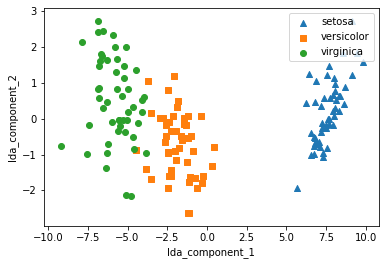

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

lda_columns=['lda_component_1','lda_component_2']
irisDF_lda = pd.DataFrame(iris_lda,columns=lda_columns)
irisDF_lda['target']=iris.target

#setosa는 세모, versicolor는 네모, virginica는 동그라미로 표현
markers=['^', 's', 'o']

#setosa의 target 값은 0, versicolor는 1, virginica는 2. 각 target 별로 다른 shape으로 scatter plot
for i, marker in enumerate(markers):
    x_axis_data = irisDF_lda[irisDF_lda['target']==i]['lda_component_1']
    y_axis_data = irisDF_lda[irisDF_lda['target']==i]['lda_component_2']

    plt.scatter(x_axis_data, y_axis_data, marker=marker,label=iris.target_names[i])

plt.legend(loc='upper right')
plt.xlabel('lda_component_1')
plt.ylabel('lda_component_2')
plt.show()

# SVD 실습

In [39]:
# numpy의 svd 모듈 import
import numpy as np
from numpy.linalg import svd

# 4X4 Random 행렬 a 생성 
np.random.seed(121)
a = np.random.randn(4,4)
print(np.round(a, 3))

[[-0.212 -0.285 -0.574 -0.44 ]
 [-0.33   1.184  1.615  0.367]
 [-0.014  0.63   1.71  -1.327]
 [ 0.402 -0.191  1.404 -1.969]]


In [40]:
U, Sigma, Vt = svd(a)
print(U.shape, Sigma.shape, Vt.shape)
print('U matrix:\n',np.round(U, 3))
print('Sigma Value:\n',np.round(Sigma, 3))
print('V transpose matrix:\n',np.round(Vt, 3))

(4, 4) (4,) (4, 4)
U matrix:
 [[-0.079 -0.318  0.867  0.376]
 [ 0.383  0.787  0.12   0.469]
 [ 0.656  0.022  0.357 -0.664]
 [ 0.645 -0.529 -0.328  0.444]]
Sigma Value:
 [3.423 2.023 0.463 0.079]
V transpose matrix:
 [[ 0.041  0.224  0.786 -0.574]
 [-0.2    0.562  0.37   0.712]
 [-0.778  0.395 -0.333 -0.357]
 [-0.593 -0.692  0.366  0.189]]


In [41]:
# Sima를 다시 0 을 포함한 대칭행렬로 변환
Sigma_mat = np.diag(Sigma)
a_ = np.dot(np.dot(U, Sigma_mat), Vt)
print(np.round(a_, 3))

[[-0.212 -0.285 -0.574 -0.44 ]
 [-0.33   1.184  1.615  0.367]
 [-0.014  0.63   1.71  -1.327]
 [ 0.402 -0.191  1.404 -1.969]]


In [42]:
# 데이터셋의 row 간 의존성이 있는 경우 Sigma 값 중 2개가 0으로 변환
# 즉, 선형독립인 row 벡터의 개수가 2개 
a[2] = a[0] + a[1]
a[3] = a[0]
print(np.round(a, 3))

[[-0.212 -0.285 -0.574 -0.44 ]
 [-0.33   1.184  1.615  0.367]
 [-0.542  0.899  1.041 -0.073]
 [-0.212 -0.285 -0.574 -0.44 ]]


In [44]:
# 다시 SVD를 수행하여 Sigma 값 확인 
U, Sigma, Vt = svd(a)
print(U.shape, Sigma.shape, Vt.shape)
print('Sigma Value:\n',np.round(Sigma, 3))

(4, 4) (4,) (4, 4)
Sigma Value:
 [2.663 0.807 0.    0.   ]


In [45]:
# U 행렬의 경우는 Sigma와 내적을 수행하므로 Sigma의 앞 2행에 대응되는 앞 2열만 추출
U_ = U[:, :2]
Sigma_ = np.diag(Sigma[:2])
# V 전치 행렬의 경우는 앞 2행만 추출
Vt_ = Vt[:2]
print(U_.shape, Sigma_.shape, Vt_.shape)
# U, Sigma, Vt의 내적을 수행하며, 다시 원본 행렬 복원
a_ = np.dot(np.dot(U_,Sigma_), Vt_)
print(np.round(a_, 3))

(4, 2) (2, 2) (2, 4)
[[-0.212 -0.285 -0.574 -0.44 ]
 [-0.33   1.184  1.615  0.367]
 [-0.542  0.899  1.041 -0.073]
 [-0.212 -0.285 -0.574 -0.44 ]]


# Truncated SVD

In [46]:
import numpy as np
from scipy.sparse.linalg import svds
from scipy.linalg import svd

# 원본 행렬을 출력하고, SVD를 적용할 경우 U, Sigma, Vt 의 차원 확인 
np.random.seed(121)
matrix = np.random.random((6, 6))
print('원본 행렬:\n',matrix)
U, Sigma, Vt = svd(matrix, full_matrices=False)
print('\n분해 행렬 차원:',U.shape, Sigma.shape, Vt.shape)
print('\nSigma값 행렬:', Sigma)

# Truncated SVD로 Sigma 행렬의 특이값을 4개로 하여 Truncated SVD 수행
num_components = 4
U_tr, Sigma_tr, Vt_tr = svds(matrix, k=num_components)
print('\nTruncated SVD 분해 행렬 차원:',U_tr.shape, Sigma_tr.shape, Vt_tr.shape)
print('\nTruncated SVD Sigma값 행렬:', Sigma_tr)
matrix_tr = np.dot(np.dot(U_tr,np.diag(Sigma_tr)), Vt_tr)  # output of TruncatedSVD

# 완벽하게 복원되지 않고 근사적으로 복원됨을 알 수 있음
print('\nTruncated SVD로 분해 후 복원 행렬:\n', matrix_tr)

원본 행렬:
 [[0.11133083 0.21076757 0.23296249 0.15194456 0.83017814 0.40791941]
 [0.5557906  0.74552394 0.24849976 0.9686594  0.95268418 0.48984885]
 [0.01829731 0.85760612 0.40493829 0.62247394 0.29537149 0.92958852]
 [0.4056155  0.56730065 0.24575605 0.22573721 0.03827786 0.58098021]
 [0.82925331 0.77326256 0.94693849 0.73632338 0.67328275 0.74517176]
 [0.51161442 0.46920965 0.6439515  0.82081228 0.14548493 0.01806415]]

분해 행렬 차원: (6, 6) (6,) (6, 6)

Sigma값 행렬: [3.2535007  0.88116505 0.83865238 0.55463089 0.35834824 0.0349925 ]

Truncated SVD 분해 행렬 차원: (6, 4) (4,) (4, 6)

Truncated SVD Sigma값 행렬: [0.55463089 0.83865238 0.88116505 3.2535007 ]

Truncated SVD로 분해 후 복원 행렬:
 [[0.19222941 0.21792946 0.15951023 0.14084013 0.81641405 0.42533093]
 [0.44874275 0.72204422 0.34594106 0.99148577 0.96866325 0.4754868 ]
 [0.12656662 0.88860729 0.30625735 0.59517439 0.28036734 0.93961948]
 [0.23989012 0.51026588 0.39697353 0.27308905 0.05971563 0.57156395]
 [0.83806144 0.78847467 0.93868685 0.72673231 

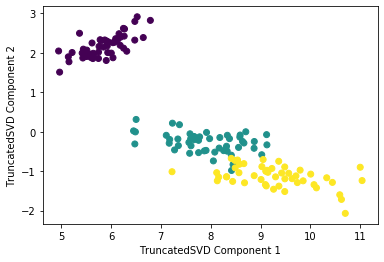

In [51]:
# 사이킷런의 Truncated SVD 클래스는 PCA 클래스와 유사하게 fit(), transform()을 호출해
# 원본데이터를 몇 개의 주요 컴포넌트로 차원을 축소해 변환해줌 
from sklearn.decomposition import TruncatedSVD
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
%matplotlib inline

iris = load_iris()
iris_ftrs = iris.data
# 2개의 주요 component로 TruncatedSVD 변환
tsvd = TruncatedSVD(n_components=2)
tsvd.fit(iris_ftrs)
iris_tsvd = tsvd.transform(iris_ftrs)

# Scatter plot 2차원으로 TruncatedSVD 변환 된 데이터 표현. 품종은 색깔로 구분
plt.scatter(x=iris_tsvd[:,0], y= iris_tsvd[:,1], c= iris.target)
plt.xlabel('TruncatedSVD Component 1')
plt.ylabel('TruncatedSVD Component 2')
plt.show()

# PCA와 유사하게 변환 후에 품종별로 어느정도 클러스터링이 가능할 정도로 
# 각 변환 속성으로 뛰어난 고유성을 가지고 있음을 알 수 있음 

# Truncated SVD v.s. PCA

Text(0.5, 1.0, 'PCA Transformed')

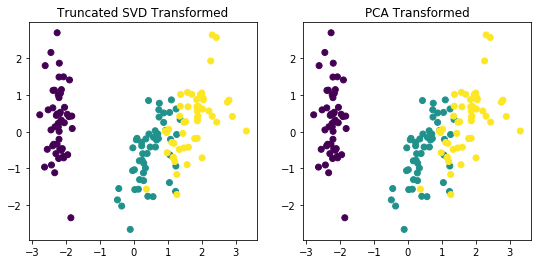

In [49]:
# 사이킷런의 Truncated SVD, PCA 클래스 구현을 살펴보면 모두 SVD를 이용해 행렬을 분해함 
from sklearn.preprocessing import StandardScaler

# iris 데이터를 StandardScaler로 변환
scaler = StandardScaler()
iris_scaled = scaler.fit_transform(iris_ftrs)

# 스케일링된 데이터를 기반으로 TruncatedSVD 변환 수행 
tsvd = TruncatedSVD(n_components=2)
tsvd.fit(iris_scaled)
iris_tsvd = tsvd.transform(iris_scaled)

# 스케일링된 데이터를 기반으로 PCA 변환 수행 
pca = PCA(n_components=2)
pca.fit(iris_scaled)
iris_pca = pca.transform(iris_scaled)

# TruncatedSVD 변환 데이터를 왼쪽에, PCA변환 데이터를 오른쪽에 표현 
fig, (ax1, ax2) = plt.subplots(figsize=(9,4), ncols=2)
ax1.scatter(x=iris_tsvd[:,0], y= iris_tsvd[:,1], c= iris.target)
ax2.scatter(x=iris_pca[:,0], y= iris_pca[:,1], c= iris.target)
ax1.set_title('Truncated SVD Transformed')
ax2.set_title('PCA Transformed')

In [52]:
# 두 개의 변환 행렬 값과 원본 속성별 컴포넌트 비율값을 비교해보면 거의 같음을 알 수 있음 
# 모두 0에 가까운 값 -> 2개의 변환이 서로 동일
# 스케일링으로 인해 데이터 중심이 동일해지면 사이킷런의 SVD와 PCA는 동일한 변환을 수행
# 이는 PCA가 SVD 알고리즘으로 구현됐음을 의미
print((iris_pca - iris_tsvd).mean())
print((pca.components_ - tsvd.components_).mean())

-3.9685307484615753
0.14980502560478295


# NMF 실습

C:\Users\USER\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Text(0, 0.5, 'NMF Component 2')

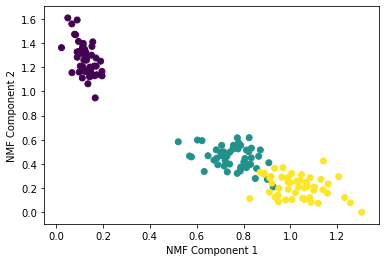

In [53]:
from sklearn.decomposition import NMF
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
%matplotlib inline

iris = load_iris()
iris_ftrs = iris.data
nmf = NMF(n_components=2)
nmf.fit(iris_ftrs)
iris_nmf = nmf.transform(iris_ftrs)
plt.scatter(x=iris_nmf[:,0], y= iris_nmf[:,1], c= iris.target)
plt.xlabel('NMF Component 1')
plt.ylabel('NMF Component 2')